## install

In [67]:
try:
    import open3d as o3d
except ModuleNotFoundError:
    !pip install open3d

try:
    import trimesh
except ModuleNotFoundError:
    !pip install trimesh

import os
import sys
import colorsys
import shutil
import numpy as np
import pandas as pd
# import open3d as o3d
# import trimesh
from shapely.geometry import LineString
%pylab inline
%config InlineBackend.figure_format = 'svg'
from sklearn.cluster import KMeans
from scipy.spatial.distance import pdist, squareform
from IPython.display import display,Image, HTML
import plotly.graph_objects as go


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/pylab.py:159: UserWarning:

pylab import has clobbered these variables: ['axis', 'figure']
`%matplotlib` prevents importing * from pylab and numpy



## 関数

In [3]:
def add_custom_points(pcd):
    # x、y、z座標を取得
    points = np.asarray(pcd.points)

    # 最大値と最小値を計算
    x_min, x_max = np.min(points[:, 0]), np.max(points[:, 0])
    y_min, y_max = np.min(points[:, 1]), np.max(points[:, 1])
    z_min, z_max = np.min(points[:, 2]), np.max(points[:, 2])

    # x、y、zの最大値と最小値の差の最大値を計算
    max_difference = max(x_max - x_min, y_max - y_min, z_max - z_min)

    # 新しい点を追加する座標を計算する
    new_points = np.array([[x_min+max_difference, y_min+max_difference, z_min+max_difference/2], [x_min, y_min, z_max-max_difference/2]])
    

    # 新しい点の色を白に設定する
    new_colors = np.array([[1, 1, 1], [1, 1, 1]])

    # 現在の点群データに新しい点を追加する
    pcd.points = o3d.utility.Vector3dVector(np.vstack([pcd.points, new_points]))
    pcd.colors = o3d.utility.Vector3dVector(np.vstack([pcd.colors, new_colors]))

    return pcd


def generate_points(length):
    n = int(length * 10)
    x = np.zeros(n)
    y = np.linspace(0, length, n)
    z = np.zeros(n)
    points = np.vstack((x, y, z)).T

    return np_to_pcd(points)

In [4]:
def pcd_plotly(pcd):
  # np_pcd = np.asarray(pcd.points) 
  # max_value = np.max(np_pcd)
  # min_value = np.min(np_pcd)
  # pcd_add = add_custom_points(pcd,max_value,min_value)
  pcd_add = add_custom_points(pcd)
  o3d.visualization.draw_plotly([pcd_add])

def down_sample_pcd_plotly(pcd):
  pcd_down = pcd.uniform_down_sample(every_k_points=10)
  pcd_plotly(pcd_down)

def down_sample_colorbar_pcd_plotly(pcd):
  color_b = o3d.geometry.PointCloud()
  color_b.points = o3d.utility.Vector3dVector(pcd.colors)
  color_b.colors = o3d.utility.Vector3dVector(pcd.colors)
  down_sample_pcd_plotly(color_b)

def colorbar_pcd_plotly(pcd):
  color_b = o3d.geometry.PointCloud()
  color_b.points = o3d.utility.Vector3dVector(pcd.colors)
  color_b.colors = o3d.utility.Vector3dVector(pcd.colors)
  pcd_plotly(color_b)


In [5]:
## 座標とRGBを配列化
xyz = ['x','y','z']
rgb = ['r','g','b']

def copy_pcd(pcd):
  pccd_copy = o3d.geometry.PointCloud()
  pccd_copy.points = o3d.utility.Vector3dVector(pcd.points)
  pccd_copy.colors = o3d.utility.Vector3dVector(pcd.colors)
  return pccd_copy

def pcd_to_df(pcd):
  xyz = ['x','y','z']
  rgb = ['r','g','b']

  np_doki = np.asarray(pcd.points)
  np_col = np.asarray(pcd.colors) #* 255.0
  ## xyzrgb　の並びにする
  df1 = pd.DataFrame(data=np_doki, columns=xyz)
  df2 = pd.DataFrame(np_col, columns=rgb)
  df_pcd = pd.concat([df1, df2], axis=1)
  return df_pcd

def df_to_pcd(df):
  xyz = ['x','y','z']
  rgb = ['r','g','b']
  pcd_doki2 = o3d.geometry.PointCloud()
  pcd_doki2.points = o3d.utility.Vector3dVector(df[xyz].values)
  pcd_doki2.colors = o3d.utility.Vector3dVector(df[rgb].values)
  return pcd_doki2


### dfを点群として表示
def down_sample_df_plotly(df):
  down_sample_pcd_plotly(df_to_pcd(df))

def df_plotly(df):
  xyz = ['x','y','z']
  rgb = ['r','g','b']

  pcd_doki2 = o3d.geometry.PointCloud()
  pcd_doki2.points = o3d.utility.Vector3dVector(df[xyz].values)
  pcd_doki2.colors = o3d.utility.Vector3dVector(df[rgb].values)
  # down_sample_pcd_plotly(pcd_doki2)
  pcd_plotly(pcd_doki2)

def colorbar_df_plotly(df):
  xyz = ['x','y','z']
  rgb = ['r','g','b']

  pcd_doki2 = o3d.geometry.PointCloud()
  pcd_doki2.points = o3d.utility.Vector3dVector(df[rgb].values)
  pcd_doki2.colors = o3d.utility.Vector3dVector(df[rgb].values)
  pcd_plotly(pcd_doki2)
  # down_sample_pcd_plotly(pcd_doki2)

def separate_df_plotly(df_xyz,df_rgb):

  pcd_doki2 = o3d.geometry.PointCloud()
  pcd_doki2.points = o3d.utility.Vector3dVector(df_xyz.values)
  pcd_doki2.colors = o3d.utility.Vector3dVector(df_rgb.values)
  down_sample_pcd_plotly(pcd_doki2)
  # o3d.visualization.draw_plotly([pcd_doki2])



In [6]:
def get_pcd_plane_nonplane(pcd_doki,distance_threshold=0.01 ,ransac_n=100 ,num_iterations=5000):
  # RANSAC平面検出を実行
  plane_model, inliers = pcd_doki.segment_plane(distance_threshold=distance_threshold,
                                            ransac_n=ransac_n,
                                            num_iterations=num_iterations)


  # 平面に属する点だけの点群を作成
  pcd_plane = pcd_doki.select_by_index(inliers)

  # 平面以外の点だけの点群を作成
  pcd_nonplane = pcd_doki.select_by_index(inliers, invert=True)
  return pcd_plane,pcd_nonplane

In [7]:
def max_distance(pcd):
    """
    Calculates the maximum distance between any two points in a dataframe containing
    3D point coordinates.
    
    Parameters:
    df (pandas.DataFrame): A dataframe containing the 3D point coordinates. The dataframe
                           must have columns named 'x', 'y', and 'z'.
                           
    Returns:
    float: The maximum distance between any two points in the dataframe.
    """
    # Extract the coordinates as a numpy array
    # coords = df[['x', 'y', 'z']].values
    coords = np.asarray(pcd.points)
    
    # Calculate the pairwise distance matrix between all points
    dist_matrix = np.sqrt(((coords[:, None] - coords)**2).sum(-1))
    
    # Ignore the diagonal (distance between a point and itself)
    np.fill_diagonal(dist_matrix, 0)
    
    # Return the maximum distance
    max_distance = dist_matrix.max()

    return max_distance

In [8]:
# DBSCANアルゴリズムによるクラスタリングを行いクラスタ毎にリスト形式で返す
def get_pcd_cluster_list(pcd,scale,eps=0.02,min_points=50):
  with o3d.utility.VerbosityContextManager(
          o3d.utility.VerbosityLevel.Debug) as cm:
      labels = np.array(
          pcd.cluster_dbscan(eps=eps*scale, min_points=min_points, print_progress=True))

  pcd_list = []
  for i in range(labels.max()+1):
      indices = np.where(labels == i)[0]
      pcd_cluster = pcd.select_by_index(indices)
      # pcd_cluster.paint_uniform_color(colors[i][:3])
      pcd_list.append(pcd_cluster)
  return pcd_list,labels


def clusterd_pcd_list_plotly(pc_list):
    if len(pc_list) == 1:
        down_sample_pcd_plotly(pc_list[0])
    else:
      merged_pc = o3d.geometry.PointCloud()
      points = []
      colors = []
      for i, pc in enumerate(pc_list):
          points.extend(np.asarray(pc.points))
          colors.extend([[i/(len(pc_list)-1), 1-i/(len(pc_list)-1), 0]]*len(pc.points))
      merged_pc.points = o3d.utility.Vector3dVector(points)
      merged_pc.colors = o3d.utility.Vector3dVector(colors)
      # return merged_pc
      down_sample_pcd_plotly(merged_pc)

In [9]:
def get_max_count_attribute(df, column_name):
    # 指定された列について属性毎のレコード数を数える
    attribute_counts = df[column_name].value_counts()
    # レコード数が最大である属性を返す
    return attribute_counts.idxmax()

In [10]:
# 要素数が最大であるもののリストインデックスを返す
def max_len_index(pcd_list):
  lengths = [len(p.points) for p in pcd_list]
  max_index = np.argmax(lengths)
  return max_index


In [11]:
def dog_axis(right_eye, left_eye, nose ,zzz):
    origin = (right_eye + left_eye) / 2
    #原点を両目の中点とする
    px = right_eye - left_eye
    # x軸は左目→右目
    py = nose - origin
    # 「しっぽから鼻にむかう直線」

    """それぞれの単位ベクトルを計算"""
    ex = px / np.linalg.norm(px)
    ez = np.cross(px, py) / np.linalg.norm(np.cross(px, py))
    ey = np.cross(ez, ex)

    """変換行列 4x4 を作成"""
    #ローカル座標（犬から見た座標）を絶対座標に変換する行列
    R_LtoG = np.identity(4)

    R_LtoG[:3, :3] = np.array([ex, ey, ez]).T
    #回転行列を代入
    R_LtoG[:3, 3] = origin
    #移動ベクトルを代入

    #絶対座標からローカル座標（犬からみた座標）に変換する行列
    R_GtoL = np.identity(4)*zzz
    R_GtoL[:3, :3] = np.array([ex, ey, ez])
    R_GtoL[:3, 3] = - np.dot(np.array([ex, ey, ez]), origin)

    return (R_GtoL)

def get_3kmeans(pcd):
  # 3点を抽出
  X = pcd.points
  kmeans = KMeans(n_clusters=3, random_state=9).fit(X)
  points = kmeans.cluster_centers_
  return points

def get_ijk(points):
    # 2点間の距離を計算
    distances = pdist(points)

    # 距離行列を作成
    distance_matrix = squareform(distances)

    # 最も距離が大きい2点を探す
    i, j = np.unravel_index(np.argmax(distance_matrix), distance_matrix.shape)

    # 残りの1点のインデックスを取得
    k = np.setdiff1d(np.arange(3), [i, j])[0]
    point_i = points[i]
    point_j = points[j]
    point_k = points[k]

    # point_iとpoint_jのうち、x座標が大きい方をrightとする
    if point_i[0] < point_j[0]:
        return point_j, point_i, point_k
    else :
        return point_i, point_j, point_k

    
def get_R_GtoL(points):
  # 3点を抽出
  # X = df[xyz].values
  # kmeans = KMeans(n_clusters=3, random_state=9).fit(X)
  # points = kmeans.cluster_centers_

  point_i,point_j,point_k = get_ijk(points)

  R_GtoL = dog_axis(point_i, point_j, point_k,1)
  
  return R_GtoL

In [12]:
def reverse_z_axis(pc: o3d.geometry.PointCloud, p: float) -> o3d.geometry.PointCloud:
    # Open3DのPointCloudからnumpy配列に変換
    points = np.asarray(pc.points)

    # z座標がpより大きい点の数を数える
    count = np.count_nonzero(points[:, 2] > p)

    # z座標がpより大きい点の割合が50%以上の場合、z軸を反転する
    if count / points.shape[0] > 0.5:
        points[:, 2] = -points[:, 2]

    # numpy配列からOpen3DのPointCloudに変換して返す
    pc_reversed = o3d.geometry.PointCloud()
    pc_reversed.points = o3d.utility.Vector3dVector(points)
    pc_reversed.colors = o3d.utility.Vector3dVector(pc.colors)
    return pc_reversed


In [13]:
def calculate_circle(points):
    """
    3つの点を通る円の中心座標と半径を計算する関数

    Parameters
    ----------
    points : array-like, shape (3, 2)
        3つのXY座標を持つNumPy配列

    Returns
    -------
    float, float, float
        円の中心座標のX座標、Y座標、半径
    """

    # 各点の座標を変数に代入
    x1, y1 = points[0]
    x2, y2 = points[1]
    x3, y3 = points[2]

    # 3点を通る円の中心座標を計算
    D = 2 * (x1 * (y2 - y3) + x2 * (y3 - y1) + x3 * (y1 - y2))
    Ux = ((x1 ** 2 + y1 ** 2) * (y2 - y3) + (x2 ** 2 + y2 ** 2) * (y3 - y1) + (x3 ** 2 + y3 ** 2) * (y1 - y2)) / D
    Uy = ((x1 ** 2 + y1 ** 2) * (x3 - x2) + (x2 ** 2 + y2 ** 2) * (x1 - x3) + (x3 ** 2 + y3 ** 2) * (x2 - x1)) / D

    # 3点を通る円の半径を計算
    R = np.sqrt((x1 - Ux) ** 2 + (y1 - Uy) ** 2)

    return Ux, Uy, R

In [14]:
def plt_circle_2D(np_z,cx, cy, radius):

  # 角度を0から360度まで0.1刻みで生成
  theta = np.linspace(0, 2 * np.pi, 100)

  # 円のx, y座標を計算
  x = radius * np.cos(theta) + cx
  y = radius * np.sin(theta) + cy

  # 円を描画
  plt.plot(x, y, 'r-', linewidth=1)  # 線の色を青、線幅を2に設定

  # X座標を取得
  xx = np_z[:, 0]
  # Y座標を取得
  yy = np_z[:, 1]
  plt.plot(xx,yy , 'bo')  # 赤色の点をプロット

  plt.axis('equal')  # X軸とY軸のスケールを等しく設定
  plt.xlabel('X')  # X軸のラベルを設定
  plt.ylabel('Y')  # Y軸のラベルを設定

  plt.show()  # グラフを表示
def generate_circle_3D(center: np.ndarray, radius: float, num_points: int) -> o3d.geometry.PointCloud:
    # X, Y座標をnum_points個の点で均等に分割する
    angles = np.linspace(0, 2 * np.pi, num_points, endpoint=False)
    xs = center[0] + radius * np.cos(angles)
    ys = center[1] + radius * np.sin(angles)
    zs = np.zeros(num_points)

    # 座標を結合してPointCloudに変換する
    points = np.vstack((xs, ys, zs)).T
    pointcloud = o3d.geometry.PointCloud()
    pointcloud.points = o3d.utility.Vector3dVector(points)

    return pointcloud

In [15]:
def adjust_scale_pcd(pcd,scale):
  pcd2 = copy_pcd(pcd)
  pcd2.scale(scale, center=pcd2.get_center())
  return pcd2

In [16]:
def add_red_color(pcd):
    """
    点群データに赤い色を付加する関数

    Parameters
    ----------
    pcd : open3d.geometry.PointCloud
        対象となる点群データ

    Returns
    -------
    open3d.geometry.PointCloud
        赤い色が付加された点群データ
    """

    # 全点を赤い色にする
    colors = np.tile([1, 0, 0], (np.asarray(pcd.points).shape[0], 1))
    
    # 点群オブジェクトに色情報をセット
    pcd.colors = o3d.utility.Vector3dVector(colors)
    
    return pcd

def combine_pcd(pcd,pcd２):
  pcd_a =  pcd if pcd.has_colors() else add_red_color(pcd)
  pcd_b =  pcd2 if pcd2.has_colors() else add_red_color(pcd2)

  # 合体
  combined_pcd = o3d.geometry.PointCloud()
  combined_pcd.points = o3d.utility.Vector3dVector(np.concatenate((np.asarray(pcd_a.points), np.asarray(pcd_b.points))))
  combined_pcd.colors = o3d.utility.Vector3dVector(np.concatenate((np.asarray(pcd_a.colors), np.asarray(pcd_b.colors))))
  return combined_pcd

def np_to_pcd(np):
  points_o3d = o3d.utility.Vector3dVector(np)
  pcd = o3d.geometry.PointCloud(points_o3d)
  return pcd

In [17]:
# メッシュ化
def pcd_to_mesh(pcd_moved_points,r=10,):

  #ダウンサンプリングしたものしか処理できないけど計算資源あればいけるかも:TODO　点の数でダウンサンプリングするかどうか決めるべし
  pcd_doki_down3 = pcd_moved_points.uniform_down_sample(every_k_points=10)
  
  # 法線推定
  pcd_doki_down3.estimate_normals()

  # 法線推定調整時の半径が重要！土器の最薄の厚みを考えないと
  pcd_doki_down3.orient_normals_consistent_tangent_plane(r)

  # ポアソン曲面
  with o3d.utility.VerbosityContextManager(
          o3d.utility.VerbosityLevel.Debug) as cm:
      mesh_doki, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd_doki_down3, depth=10)
  return mesh_doki

In [18]:
# メッシュ化
def pcd_to_mesh2(pcd_moved_points,r=10 ,depth=10):

  #ダウンサンプリングしたものしか処理できないけど計算資源あればいけるかも:TODO　点の数でダウンサンプリングするかどうか決めるべし
  pcd_doki_down3 = pcd_moved_points
  
  # 法線推定
  pcd_doki_down3.estimate_normals()

  # 法線推定調整時の半径が重要！土器の最薄の厚みを考えないと
  pcd_doki_down3.orient_normals_consistent_tangent_plane(r)

  # ポアソン曲面
  with o3d.utility.VerbosityContextManager(
          o3d.utility.VerbosityLevel.Debug) as cm:
      mesh_doki, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd_doki_down3, depth=depth)
  return mesh_doki

In [19]:
def slice_mesh(mesh_doki):
  # open3d.cpu.pybind.geometry.TriangleMesh を trimesh.base.Trimesh オブジェクトに変換
  trimesh_doki = trimesh.Trimesh(vertices=np.asarray(mesh_doki.vertices),
                                faces=np.asarray(mesh_doki.triangles))

  # スライス
  slice = trimesh_doki.section(plane_origin=(0,0,0),
                      plane_normal=[1,0,0])

  to_2D = trimesh.geometry.align_vectors([0,0,1], [1,0,0])

  slice_2D, to_3D = slice.to_planar(to_2D = to_2D)
  return slice_2D

In [20]:
import matplotlib.pyplot as plt
def path2Dshow(Path2D,radius,z_min):
        # if Path2Dis_closed:
              # plt.cla()
              # axis = plt.gca()
              fig, axis = plt.subplots()
              axis.set_aspect('equal', 'datalim')

              for i, points in enumerate(Path2D.discrete):
                  # 転置が必要
                  # axis.plot(*points.T, color=(0,0,1))
                  axis.plot(*points[:, ::-1].T, color=(0,0,1), alpha = 0.4)
              
              plt.hlines(0,-radius,radius,color="blue", alpha = 0.4)
              plt.vlines(0,z_min,0,color="blue", alpha = 0.4)

              # 目盛線を設定
              axis.grid(which = "major", axis = "x", color = "green", alpha = 0.3, linewidth = 1)
              axis.grid(which = "major", axis = "y", color = "green", alpha = 0.3, linewidth = 1)
              
              # 補助目盛線を設定
              axis.minorticks_on()
              axis.grid(which = "minor", axis = "x", color = "green", alpha = 0.3, linestyle = "--", linewidth = 0.5)
              axis.grid(which = "minor", axis = "y", color = "green", alpha = 0.3, linestyle = "--", linewidth = 0.5)
              
              # plt.show()
              
              return fig, axis
        # else:
        #     return 'is_not_closed'

In [21]:
def add_hsv_df(df):

  # RGBからHSVへの変換を行い、新しいDataFrameに追加する
  hsv_list = []
  for r, g, b in zip(df['r'], df['g'], df['b']):
      h, s, v = colorsys.rgb_to_hsv(r, g, b)
      hsv_list.append([h, s, v])

  hsv_df = pd.DataFrame(hsv_list, columns=['h', 's', 'v'])
  df = pd.concat([df, hsv_df], axis=1)
  return df

def hsv_df_plotly(df):
  pcd_doki2 = o3d.geometry.PointCloud()
  pcd_doki2.points = o3d.utility.Vector3dVector(df[['h','s','v']].values)
  pcd_doki2.colors = o3d.utility.Vector3dVector(df[['r','g','b']].values)
  down_sample_pcd_plotly(pcd_doki2)

def xyzhsv_df_plotly(df):
  pcd_doki2 = o3d.geometry.PointCloud()
  pcd_doki2.points = o3d.utility.Vector3dVector(df[['x','y','z']].values)
  pcd_doki2.colors = o3d.utility.Vector3dVector(df[['h','s','v']].values)
  down_sample_pcd_plotly(pcd_doki2)

def hsv_pcd_plotly(pcd):
  df = pcd_to_df(pcd)
  df = add_hsv_df(df)
  # print(df)
  hsv_df_plotly(df)

def down_sample_hsv_pcd_plotly(pcd):
  pcd_down = pcd.uniform_down_sample(every_k_points=10)
  hsv_pcd_plotly(pcd_down)

In [22]:
def select_doki_pcd(pcd_nonplane_scaled,labels,from_color,to_color):
  ## ラベルを追加
  df_nonplane = pcd_to_df(pcd_nonplane_scaled)
  df_nonplane['label'] = labels

  ### hsv色情報を追加：色相（Hue）、彩度（Saturation）、明度（Value）
  df_nonplane_hsv = add_hsv_df(df_nonplane)
  # hsv_df_plotly(df_nonplane_hsv)
  
  ### blueの支え粘土を識別
  df_blue = df_nonplane_hsv.query('h > @from_color & h < @to_color & s > 0.2')
  # hsv_df_plotly(df_blue)
  # df_plotly(df_blue)

  ### blue点が一番多いラベル番号を判定
  doki_label = get_max_count_attribute(df_blue,'label')

  ### 土器本体と推定される部分を抽出
  df_doki = df_nonplane_hsv.query('label == @doki_label')
  # df_doki2 = df_doki.query('h < @from_color | h > @to_color | s < 0.2')
  # down_sample_df_plotly(df_doki2)
  
  return df_to_pcd(df_doki)

In [23]:
# print(1/6) :0.17
# print(5/6) :0.83

In [24]:
def select_pcd_by_hsv(pcd ,from_h ,to_h ,from_s=0.2 ,from_v=0.4):

  df = pcd_to_df(pcd)
  df_hsv = add_hsv_df(df)
  df_hsv2 = df_hsv.query('h > @from_h & h < @to_h & s > @from_s  & v > @from_v ')
  # hsv_df_plotly(df_hsv)
  # hsv_df_plotly(df_hsv2)
  # df_plotly(df_hsv2)

  return df_to_pcd(df_hsv2)

def except_pcd_by_hsv(pcd ,from_h ,to_h ,from_s=0.2 ,from_v=0.4):

  df = pcd_to_df(pcd)
  df_hsv = add_hsv_df(df)
  df_hsv2 = df_hsv.query('h < @from_h | h > @to_h | s < @from_s  | v < @from_v ')
  # hsv_df_plotly(df_hsv)
  # hsv_df_plotly(df_hsv2)
  # df_plotly(df_hsv2)

  return df_to_pcd(df_hsv2)


# except_pcd_by_hsv(pcd_doki2,0.11,0.75)
# o3d.visualization.draw_plotly([pcd_doki2])

In [25]:
def generate_rotation_matrix(points):
    """
    指定された3点をz=0になる平面に移動させる回転行列を生成する関数

    Parameters
    ----------
    points : numpy.ndarray, shape (3, 3)
        移動前の3点の座標

    Returns
    -------
    rotation_matrix : numpy.ndarray, shape (3, 3)
        回転行列
    """

    # 平面上に移動するために、3点の重心を原点に移動する
    centroid = np.mean(points, axis=0)
    points_centered = points - centroid

    # 3点を通る法線ベクトルを計算する
    normal = np.cross(points_centered[1] - points_centered[0], points_centered[2] - points_centered[0])
    normal /= np.linalg.norm(normal)

    # z軸方向のベクトルを定義する
    z_axis = np.array([0, 0, 1])

    # 法線ベクトルとz軸方向のベクトルとの間の回転角度と回転軸を計算する
    rotation_axis = np.cross(z_axis, normal)
    rotation_angle = np.arccos(np.dot(z_axis, normal))

    # 回転行列を生成する
    rotation_matrix = np.eye(3) + np.sin(rotation_angle) * np.array([[0, -rotation_axis[2], rotation_axis[1]],
                                                                    [rotation_axis[2], 0, -rotation_axis[0]],
                                                                    [-rotation_axis[1], rotation_axis[0], 0]]) \
                                    + (1 - np.cos(rotation_angle)) * np.outer(rotation_axis, rotation_axis)

    
    # 平面上に移動させるための変換行列を生成する
    transformation_matrix = np.eye(4)
    transformation_matrix[:3, :3] = rotation_matrix
    translation = np.array([0, 0, -centroid[2]])
    transformation_matrix[:3, 3] = translation

    return transformation_matrix
    # T = np.zeros((4, 4))
    # T[:3, :3] = rotation_matrix  # 回転行列XをTの上部左側に配置
    # T[3, 3] = 1    # Tの最下部右側の要素を1に設定
    # return T
# x =generate_rotation_matrix(np_points)

In [26]:
def move_origin(pcd,cx,cy):
    """
    点群データを指定された原点に移動する関数

    Returns
    -------
    pcd_moved_points : numpy.ndarray, shape (N, 3)
        移動後の点群データを表すnumpy配列
    """
    translation = np.array([0,0,0]) - np.array([cx,cy,0])
    moved_points = np.asarray(pcd.points) - np.array([cx,cy,0])

    pcd_moved_points = o3d.geometry.PointCloud()
    pcd_moved_points.points = o3d.utility.Vector3dVector(moved_points)
    pcd_moved_points.colors = o3d.utility.Vector3dVector(pcd.colors)


    return pcd_moved_points


In [27]:
def move_to_zplane(pcd_doki2,np_points):

  # 口縁がZ＝０平面に来るように点群を移動
  ## 元の点群から口縁用のマーカー点を除いて位置移動
  R_GtoL = get_R_GtoL(np_points)
  # R_GtoL = generate_rotation_matrix(np_points)
  pcd_moved = pcd_doki2.transform(R_GtoL)

  ## 土器の上下が逆転していないか
  pcd_moved_z = reverse_z_axis(pcd_moved,0)

  # 口縁半径推定
  ## 口縁の代表点を移動
  pcd_points = np_to_pcd(np_points)
  pcd_points_moved = pcd_points.transform(R_GtoL)

  ## 口縁の代表点で円を推定
  np_points_moved = np.asarray(pcd_points_moved.points)
  cx, cy, radius = calculate_circle(np_points_moved[:, :2])

  ## 推定した円の中心が[0,0,0]になるように移動
  pcd_moved_origin = move_origin(pcd_moved_z,cx,cy)

  return pcd_moved_origin,radius

In [28]:
def extract_filename(filepath):
    """
    # ファイルパスから拡張子を除いたファイル名を抽出する関数
    
    Parameters
    ----------
    filepath : str
        ファイルパス
    
    Returns
    -------
    str
        拡張子を除いたファイル名
    """
    basename = os.path.basename(filepath) # ファイルパスからファイル名を取得
    filename_without_ext = os.path.splitext(basename)[0] # ファイル名から拡張子を除いた部分を取得
    return filename_without_ext

def extract_path(filepath):
    """
    ファイルパスから拡張子を除いたパスを取得する関数
    """
    basename = os.path.basename(filepath)  # ファイル名のみを取得
    name_without_extension = os.path.splitext(basename)[0]  # 拡張子を除いたファイル名を取得
    dirpath = os.path.dirname(filepath)  # ファイルがあるディレクトリのパスを取得
    path_without_extension = os.path.join(dirpath, name_without_extension)  # 拡張子を除いたファイルパスを作成
    return path_without_extension

def create_directory(path):
    """
    指定したパスのフォルダを作成する。既に存在する場合は何もしない。
    :param path: フォルダを作成するパス
    """
    if not os.path.exists(path):
        os.makedirs(path)
        print(f"Created directory: {path}")
    else:
        print(f"Directory already exists: {path}")


In [29]:
## plotlyの分解


def get_point_object(geometry, point_sample_factor=1):
    points = np.asarray(geometry.points)
    colors = None
    if geometry.has_colors():
        colors = np.asarray(geometry.colors)
    elif geometry.has_normals():
        colors = (0.5, 0.5, 0.5) + np.asarray(geometry.normals) * 0.5
    else:
        geometry.paint_uniform_color((1.0, 0.0, 0.0))
        colors = np.asarray(geometry.colors)
    if (point_sample_factor > 0 and point_sample_factor < 1):
        indices = np.random.choice(len(points),
                                   (int)(len(points) * point_sample_factor),
                                   replace=False)
        points = points[indices]
        colors = colors[indices]
    scatter_3d = go.Scatter3d(x=points[:, 0],
                              y=points[:, 1],
                              z=points[:, 2],
                              mode='markers',
                              marker=dict(size=1, color=colors))
    return scatter_3d


def get_mesh_object(geometry,):
    pl_mygrey = [0, 'rgb(153, 153, 153)'], [1., 'rgb(255,255,255)']
    triangles = np.asarray(geometry.triangles)
    vertices = np.asarray(geometry.vertices)

    mesh_3d = go.Mesh3d(x=vertices[:, 0],
                        y=vertices[:, 1],
                        z=vertices[:, 2],
                        i=triangles[:, 0],
                        j=triangles[:, 1],
                        k=triangles[:, 2],
                        flatshading=True,
                        colorscale=pl_mygrey,
                        intensity=vertices[:, 0],
                        lighting=dict(ambient=0.18,
                                      diffuse=1,
                                      fresnel=0.1,
                                      specular=1,
                                      roughness=0.05,
                                      facenormalsepsilon=1e-15,
                                      vertexnormalsepsilon=1e-15),
                        lightposition=dict(x=100, y=200, z=0))
    return mesh_3d


def get_wireframe_object(geometry):
    triangles = np.asarray(geometry.triangles)
    vertices = np.asarray(geometry.vertices)
    x = []
    y = []
    z = []
    tri_points = np.asarray(vertices)[triangles]
    for point in tri_points:
        x.extend([point[k % 3][0] for k in range(4)] + [None])
        y.extend([point[k % 3][1] for k in range(4)] + [None])
        z.extend([point[k % 3][2] for k in range(4)] + [None])
    wireframe = go.Scatter3d(x=x,
                             y=y,
                             z=z,
                             mode='lines',
                             line=dict(color='rgb(70,70,70)', width=1))
    return wireframe


def get_lineset_object(geometry):
    x = []
    y = []
    z = []
    line_points = np.asarray(geometry.points)[np.asarray(geometry.lines)]
    for point in line_points:
        x.extend([point[k % 2][0] for k in range(2)] + [None])
        y.extend([point[k % 2][1] for k in range(2)] + [None])
        z.extend([point[k % 2][2] for k in range(2)] + [None])
    line_3d = go.Scatter3d(x=x, y=y, z=z, mode='lines')
    return line_3d


def get_graph_objects(geometry_list,
                      mesh_show_wireframe=False,
                      point_sample_factor=1):

    graph_objects = []
    for geometry in geometry_list:
        geometry_type = geometry.get_geometry_type()

        if geometry_type == o3d.geometry.Geometry.Type.PointCloud:
            graph_objects.append(get_point_object(geometry,
                                                  point_sample_factor))

        if geometry_type == o3d.geometry.Geometry.Type.TriangleMesh:
            graph_objects.append(get_mesh_object(geometry))
            if (mesh_show_wireframe):
                graph_objects.append(get_wireframe_object(geometry))

        if geometry_type == o3d.geometry.Geometry.Type.LineSet:
            graph_objects.append(get_lineset_object(geometry))

    return graph_objects


def get_max_bound(geometry_list):
    max_bound = [0, 0, 0]

    for geometry in geometry_list:
        bound = np.subtract(geometry.get_max_bound(), geometry.get_min_bound())
        max_bound = np.fmax(bound, max_bound)
    return max_bound


def get_geometry_center(geometry_list):
    center = [0, 0, 0]
    for geometry in geometry_list:
        center += geometry.get_center()
    np.divide(center, len(geometry_list))
    return center


def get_plotly_fig(geometry_list,
                   width=600,
                   height=400,
                   mesh_show_wireframe=False,
                   point_sample_factor=1,
                   front=None,
                   lookat=None,
                   up=None,
                   zoom=1.0):
    graph_objects = get_graph_objects(geometry_list, mesh_show_wireframe,
                                      point_sample_factor)
    geometry_center = get_geometry_center(geometry_list)
    max_bound = get_max_bound(geometry_list)
    # adjust camera to plotly-style
    if up is not None:
        plotly_up = dict(x=up[0], y=up[1], z=up[2])
    else:
        plotly_up = dict(x=0, y=0, z=1)

    if lookat is not None:
        lookat = [
            (i - j) / k for i, j, k in zip(lookat, geometry_center, max_bound)
        ]
        plotly_center = dict(x=lookat[0], y=lookat[1], z=lookat[2])
    else:
        plotly_center = dict(x=0, y=0, z=0)

    if front is not None:
        normalize_factor = np.sqrt(np.abs(np.sum(front)))
        front = [i / normalize_factor for i in front]
        plotly_eye = dict(x=zoom * 5 * front[0] + plotly_center['x'],
                          y=zoom * 5 * front[1] + plotly_center['y'],
                          z=zoom * 5 * front[2] + plotly_center['z'])
    else:
        plotly_eye = None

    camera = dict(up=plotly_up, center=plotly_center, eye=plotly_eye)
    fig = go.Figure(data=graph_objects,
                    layout=dict(
                        showlegend=False,
                        width=width,
                        height=height,
                        margin=dict(
                            l=0,
                            r=0,
                            b=0,
                            t=0,
                        ),
                        scene_camera=camera,
                    ))
    return fig


In [64]:

def create_folder(path):
    if os.path.exists(path):
        shutil.rmtree(path)
        os.makedirs(path)
        print(f"フォルダ {path} の内容を削除しました")
    else:
        os.makedirs(path)
        print(f"フォルダ {path} を作成しました")

In [52]:
## HTML化して保存
def save_plotly_html(pcd,path,name):
  pcd_add = add_custom_points(pcd)
  fig_pcd = get_plotly_fig([pcd_add])
  html_file_name = path +'/'+name+'.html'
  fig_pcd.write_html(html_file_name)

def down_sample_save_plotly_html(pcd,path,name):
  pcd_down = pcd.uniform_down_sample(every_k_points=10)
  save_plotly_html(pcd_down,path,name)


def hsv_df_save_plotly_html(df,path,name):
  pcd_doki2 = o3d.geometry.PointCloud()
  pcd_doki2.points = o3d.utility.Vector3dVector(df[['h','s','v']].values)
  pcd_doki2.colors = o3d.utility.Vector3dVector(df[['r','g','b']].values)
  down_sample_save_plotly_html(pcd_doki2,path,name)

def hsv_save_plotly_html(pcd,path,name):
  df = pcd_to_df(pcd)
  df = add_hsv_df(df)
  # print(df)
  hsv_df_save_plotly_html(df,path,name)

def clusterd_pcd_list_save_plotly_html(pc_list,path,name):
    if len(pc_list) == 1:
        down_sample_save_plotly_html(pc_list[0],path,name)
    else:
      merged_pc = o3d.geometry.PointCloud()
      points = []
      colors = []
      for i, pc in enumerate(pc_list):
          points.extend(np.asarray(pc.points))
          colors.extend([[i/(len(pc_list)-1), 1-i/(len(pc_list)-1), 0]]*len(pc.points))
      merged_pc.points = o3d.utility.Vector3dVector(points)
      merged_pc.colors = o3d.utility.Vector3dVector(colors)
      # return merged_pc
      down_sample_save_plotly_html(merged_pc,path,name)

In [59]:
def add_custom_mesh(mesh):
    # 新しい点を追加する座標を計算する
    min_bound = mesh.get_min_bound()
    max_bound = mesh.get_max_bound()

    # 最大値と最小値を計算
    x_min, x_max = min_bound[0], max_bound[0]
    y_min, y_max = min_bound[1], max_bound[1]
    z_min, z_max = min_bound[2], max_bound[2]

    # x、y、zの最大値と最小値の差の最大値を計算
    max_difference = max(x_max - x_min, y_max - y_min, z_max - z_min)
    
    new_points = np.array([[x_min+max_difference, y_min+max_difference, z_min+max_difference/2], [x_min, y_min, z_max-max_difference/2]])
    
    # 新しい点の色を白に設定する
    new_colors = np.array([[1, 1, 1], [1, 1, 1]])

    # 現在の点群データに新しい点を追加する
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(new_points)
    pcd.colors = o3d.utility.Vector3dVector(new_colors)

    return pcd

def save_plotly_html_mesh(mesh,path,name):
  mesh_add = add_custom_mesh(mesh)
  fig_pcd = get_plotly_fig([mesh,mesh_add])
  html_file_name = path +'/'+name+'.html'
  fig_pcd.write_html(html_file_name)

## 実行

In [66]:
notebook_path = os.getcwd()
print(notebook_path)

/content


In [30]:
# 1.ファイル読み込み
if 'filepath' not in locals():
  filepath = "/content/drive/MyDrive/PointCloudData/土器実測自動化/20230514-B01-01.ply"
pcd_file = o3d.io.read_point_cloud(filepath)

In [63]:
print(filepath)
down_sample_pcd_plotly(pcd_file)

Output hidden; open in https://colab.research.google.com to view.

In [31]:
# 1.5 上部に残影がある場合にそれを除外する
pcd_list0,labels0 = get_pcd_cluster_list(pcd_file,1,0.02,100) ## 点群をクラスタリングする（0回目）
pcd_doki0 = select_doki_pcd(pcd_file ,labels0 ,0.5 ,0.75)     ## 上部を除外する

[Open3D DEBUG] Precompute neighbors.
[Open3D DEBUG] Done Precompute neighbors.
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 3


In [32]:
# 2.土台の平面とそれ以外の点群（=土器本体を含む点群）に分割
pcd_plane,pcd_nonplane = get_pcd_plane_nonplane(pcd_doki0,0.01,3,100)

In [33]:
# 3.縮尺変更
pcd_scale = select_pcd_by_hsv(pcd_plane,0.15,0.25,0.2,0.4)          ## 土台の平面からScale用のマーカー点を取り出す
scale = 17.2/max_distance(pcd_scale)                        ## Scale用の点を使って縮尺を計算
pcd_nonplane_scaled = adjust_scale_pcd(pcd_nonplane,scale) ## 縮尺を土器本体を含む点群に適用
# print(scale)

In [34]:
# 4.土器本体部分の点群を抽出
pcd_list,labels = get_pcd_cluster_list(pcd_nonplane_scaled,scale,0.02,50) ## 点群をクラスタリングする（１回目）
pcd_doki_blue = select_doki_pcd(pcd_nonplane_scaled ,labels ,0.4 ,0.75)   ## 指定の色（青）を含む土器本体の点群を取り出す 土台の側面
pcd_doki = except_pcd_by_hsv(pcd_doki_blue,0.4 ,0.75,0,0.2)                       ## 支え粘土を除外
pcd_list2,labels = get_pcd_cluster_list(pcd_doki,scale,0.01,10)            ## 点群をクラスタリングする（2回目） →土器周辺の点をできるだけ除外する
pcd_doki2 = pcd_list2[max_len_index(pcd_list2)]                          ## 土器周辺の点をできるだけ除外する：一番多い点を持つリスト番号を指定

[Open3D DEBUG] Precompute neighbors.
[Open3D DEBUG] Done Precompute neighbors.
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 4
[Open3D DEBUG] Precompute neighbors.
[Open3D DEBUG] Done Precompute neighbors.
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 2


In [35]:
# 5.口縁を基準にして移動 & 半径を推定
pcd_top = select_pcd_by_hsv(pcd_doki2,0.2,0.4,0.2,0.3)       ## 口縁用のマーカー点を取り出す
cl, ind = pcd_top.remove_statistical_outlier(nb_neighbors=10, std_ratio=2.0)  # 統計的外れ値除去を実行
filtered_cloud = pcd_top.select_by_index(ind)
np_points = get_3kmeans(filtered_cloud)                             ## 口縁を代表する3点を抽出
tops = combine_pcd(filtered_cloud,np_to_pcd(np_points))   ## 表示用の口縁点群

pcd_doki_moved,radius = move_to_zplane(pcd_doki2,np_points)  ## 口縁を基準にして移動 & 半径を推定

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [36]:
# print(np_points)
# pcd_plotly(np_to_pcd(np_points))

# pcd_np = np_to_pcd(np_points).transform(R_GtoL)
# pcd_plotly(pcd_np)

In [ ]:
# 3Dで推定口縁を表示
## TODO：np_points の位置移動　→　point_kの推定 →半径をpoint_kに向けて引く,あとついでにいくつか引く

# 円の点群を作成
circle_pcd = generate_circle_3D([0, 0], radius, 200)
draw_x_axis = generate_points(radius)

# 先に削減しておく
pcd_moved_down = pcd_doki_moved.uniform_down_sample(every_k_points=10)
pcd_moved_down = pcd_doki_moved

# 合体
combined_pcd = combine_pcd(draw_x_axis,circle_pcd)
combined_pcd2 = combine_pcd(pcd_moved_down,combined_pcd)

# 表示
# pcd_plotly(combined_pcd)
# pcd_plotly(combined_pcd2)


[Open3D DEBUG] Input Points / Samples: 112420 / 112409
[Open3D DEBUG] #   Got kernel density: 3.1043591499328613 (s), 1945.48046875 (MB) / 1945.48046875 (MB) / 1945 (MB)
[Open3D DEBUG] #     Got normal field: 2.1566600799560547 (s), 2542.88671875 (MB) / 2542.88671875 (MB) / 2542 (MB)
[Open3D DEBUG] Point weight / Estimated Area: 7.578275e-06 / 8.519498e-01
[Open3D DEBUG] #       Finalized tree: 6.415138006210327 (s), 3188.70703125 (MB) / 3188.70703125 (MB) / 3188 (MB)
[Open3D DEBUG] #  Set FEM constraints: 3.293492078781128 (s), 2571.8125 (MB) / 3188.70703125 (MB) / 3188 (MB)
[Open3D DEBUG] #Set point constraints: 1.4127190113067627 (s), 2571.8125 (MB) / 3188.70703125 (MB) / 3188 (MB)
[Open3D DEBUG] Leaf Nodes / Active Nodes / Ghost Nodes: 21996101 / 1516160 / 23622241
[Open3D DEBUG] Memory Usage: 2571.812 MB
[Open3D DEBUG] # Linear system solved: 11.39707612991333 (s), 2571.8125 (MB) / 3188.70703125 (MB) / 3188 (MB)
[Open3D DEBUG] Got average: 0.26463794708251953 (s), 2571.8125 (MB) /

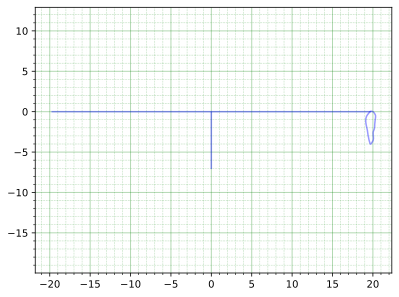

In [38]:
# 6.断面作成
mesh_doki = pcd_to_mesh2(pcd_doki_moved,depth=15)   ## メッシュ化
slice_2D = slice_mesh(mesh_doki)              ## X軸方向に輪切り 
## TODO：point_kで切るように変更
z_min = np.min(np.asarray(pcd_doki_moved.points)[:, 2])
figure,axis = path2Dshow(slice_2D,radius,z_min)                    ## 断面図化

## 出力

In [40]:
# 7.ファイル出力
filename = extract_filename(filepath)
path = extract_path(filepath)
create_folder(path)

フォルダ /content/drive/MyDrive/PointCloudData/土器実測自動化/20230514-B01-01 は既に存在します


In [41]:
figure.savefig(path + '.png')
figure.savefig(path + '.svg', format='svg')

In [49]:
down_sample_save_plotly_html(pcd_file,path,'0_pcd_file')
hsv_save_plotly_html(pcd_file,path,'0.1_pcd_file_color')

clusterd_pcd_list_save_plotly_html(pcd_list0,path,'1_clear_noise')
# down_sample_pcd_plotly(pcd_doki0)

# 2.平面とそれ以外をそれぞれ表示して確認
clusterd_pcd_list_save_plotly_html([pcd_plane,pcd_nonplane],path,'2_plane_nonplane')

# 3.縮尺変更
# スケール用の点群を表示
save_plotly_html(pcd_scale,path,'3.1_pcd_scaled')
# hsv_pcd_plotly(pcd_scale)
down_sample_save_plotly_html(pcd_nonplane_scaled,path,'3.2_pcd_nonplane_scaled')

# 4.土器本体部分の点群を抽出
clusterd_pcd_list_save_plotly_html(pcd_list,path,'4.1_blue')
# hsv_pcd_plotly(pcd_doki_blue)
down_sample_save_plotly_html(pcd_doki,path,'4.2pcd_doki')

clusterd_pcd_list_save_plotly_html(pcd_list2 ,path ,'4.3_noise')
down_sample_save_plotly_html(pcd_doki2,path,'4.4_pcd_doki2')

# 5.口縁を基準にして移動 & 半径を推定
save_plotly_html(tops,path,'5.1_tops')
save_plotly_html(combined_pcd2,path,'5.3_combined_pcd2')

# 6.断面図化
save_plotly_html_mesh(mesh_doki,path,'6_mesh')

In [62]:
# fileX = path+'/6_mesh.html'
# display(HTML(filename=fileX))

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# down_sample_pcd_plotly(pcd_file)
# down_sample_hsv_pcd_plotly(pcd_file)
# clusterd_pcd_list_plotly(pcd_list0)
# down_sample_pcd_plotly(pcd_doki0)
# down_sample_pcd_plotly(pcd_plane)
# hsv_pcd_plotly(pcd_plane)
# 分割した土器をそれぞれ表示して確認
# clusterd_pcd_list_plotly([pcd_plane,pcd_nonplane])
# 3.縮尺変更
# スケール用の点群を表示
# pcd_plotly(pcd_scale)
# hsv_pcd_plotly(pcd_scale)
# pcd_plotly(pcd_nonplane_scaled)
# clusterd_pcd_list_plotly(pcd_list)
# hsv_pcd_plotly(pcd_doki_blue)
# hsv_pcd_plotly(pcd_doki)
# down_sample_pcd_plotly(pcd_doki)
# 4.土器本体部分の点群を抽出
# 色分け表示してクラスタリング結果を確認

# clusterd_pcd_list_plotly(pcd_list2)
# pcd_plotly(pcd_doki2)

# 口縁確認
# hsv_pcd_plotly(pcd_top)  
# tops = combine_pcd(filtered_cloud,np_to_pcd(np_points))
# pcd_plotly(tops)
# 表示
# o3d.visualization.draw_plotly([mesh_doki])
# figure.show()
# print("estimated_radius",radius)